In [1]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf

import missingno as msno

Using TensorFlow backend.


In [2]:
# seed 값 설정
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


# 1.데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴본다.
1. ID : 집을 구분하는 번호
1. date : 집을 구매한 날짜
1. price : 타겟 변수인 집의 가격
1. bedrooms : 침실의 수
1. bathrooms : 침실당 화장실 개수
1. sqft_living : 주거 공간의 평방 피트
1. sqft_lot : 부지의 평방 피트
1. floors : 집의 층 수
1. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
1. view : 집이 얼마나 좋아 보이는지의 정도
1. condition : 집의 전반적인 상태
1. grade : King County grading 시스템 기준으로 매긴 집의 등급
1. sqft_above : 지하실을 제외한 평방 피트
1. sqft_basement : 지하실의 평방 피트
1. yr_built : 집을 지은 년도
1. yr_renovated : 집을 재건축한 년도
1. zipcode : 우편번호
1. lat : 위도
1. long : 경도
1. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
1. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [5]:
y = train['price']
del train['price'] # 가격을 별도로 저장 후, 원본에서 삭제
# y = y.values # y 값만 추출

In [6]:
train_len = len(train) # 둘을 합치기 전에, 구분점(train의 길이)을 저장
data = pd.concat((train, test), axis=0)  # 합침

### 결측치 확인
먼제 데이터에 결측치가 있는지를 확인한다.
missingno 라이브러리의 matrix함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있다.

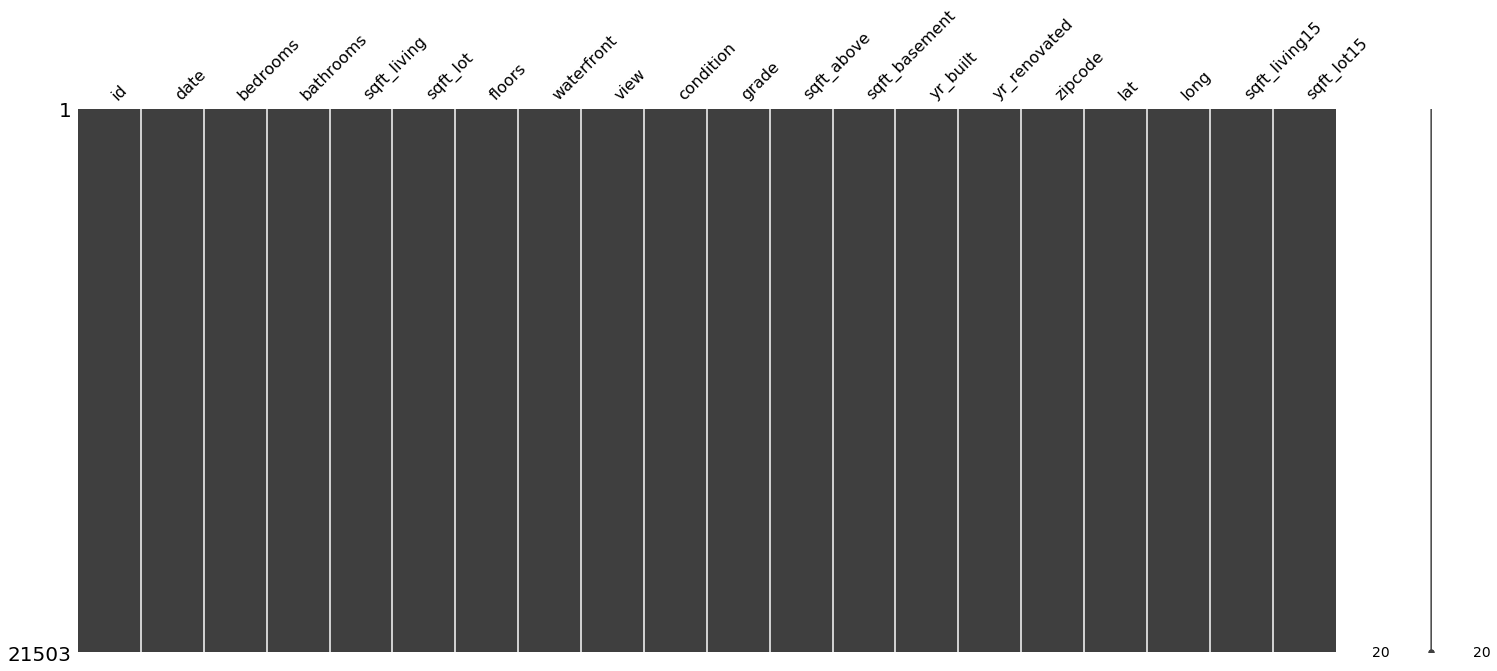

In [7]:
msno.matrix(data)

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values))) 
    # len(data.loc[pd.isnull(data[c]), c].values) - null이 있는 행, 해당 열의 값을 길이로 반환함   
    # df.loc[행인덱스, 열인덱스] 

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리

id 변수는 모델이 집값을 예측하는 데 도움을 주지 않으므로 제거한다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만든다.

In [9]:
sub_id = data['id'][train_len:] # train만 저장
del data['id']

In [10]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) # 앞에 6개만 자르고, str로 바꿔서 저장
data.tail()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,201501,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [11]:
sub = data.iloc[train_len:, :] # test
x = data.iloc[:train_len, : ] # train
print(len(x))

15035


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.001, random_state=seed) # 15035개에서 0.001인 16개만 샘프롤 꺼냄

### 모델 생성

In [13]:
model = Sequential()
model.add(Dense(40, input_dim=19, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


### 모델 컴파일

In [14]:
model.compile(loss='mean_squared_error',
             optimizer='adam')

In [15]:
model.fit(X_train, Y_train, epochs=300, batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
15019/15019 [==============================] - 11s 720us/step - loss: 149404344988.8488
Epoch 2/300
15019/15019 [==============================] - 9s 589us/step - loss: 111980545056.8629
Epoch 3/300
15019/15019 [==============================] - 9s 591us/step - loss: 76971004130.8359
Epoch 4/300
15019/15019 [==============================] - 9s 594us/step - loss: 68107071434.1035
Epoch 5/300
15019/15019 [==============================] - 9s 584us/step - loss: 66089745827.1043
Epoch 6/300
15019/15019 [==============================] - 9s 577us/step - loss: 65469891867.9710
Epoch 7/300
15019/15019 [==============================] - 9s 594us/step - loss: 64105625182.3275
Epoch 8/300
15019/15019 [==============================] - 9s 594us/step - loss: 62933454042.1088
Epoch 9/300
15019/15019 [==============================] - 7s 475us/step - loss: 61908052470.4888
Epoch 10/300
15019/15019 [==============================] - 8s 551u

15019/15019 [==============================] - 7s 483us/step - loss: 55594578354.0017
Epoch 82/300
15019/15019 [==============================] - 9s 585us/step - loss: 55791804149.5855
Epoch 83/300
15019/15019 [==============================] - 9s 582us/step - loss: 55325401344.9716
Epoch 84/300
15019/15019 [==============================] - 9s 602us/step - loss: 55502501275.6727
Epoch 85/300
15019/15019 [==============================] - 9s 589us/step - loss: 55348547255.8823
Epoch 86/300
15019/15019 [==============================] - 9s 603us/step - loss: 55513495344.9364
Epoch 87/300
15019/15019 [==============================] - 9s 600us/step - loss: 55853267309.1396
Epoch 88/300
15019/15019 [==============================] - 9s 600us/step - loss: 55354514279.4466
Epoch 89/300
15019/15019 [==============================] - 9s 598us/step - loss: 55250187897.4291
Epoch 90/300
15019/15019 [==============================] - 9s 586us/step - loss: 55514195109.2861
Epoch 91/300
15019/1501

15019/15019 [==============================] - 9s 586us/step - loss: 52000385063.3741
Epoch 164/300
15019/15019 [==============================] - 9s 585us/step - loss: 52387695448.5833
Epoch 165/300
15019/15019 [==============================] - 9s 593us/step - loss: 51853313118.1229
Epoch 166/300
15019/15019 [==============================] - 9s 592us/step - loss: 51984490535.4423
Epoch 167/300
15019/15019 [==============================] - 9s 587us/step - loss: 51505498108.6251
Epoch 168/300
15019/15019 [==============================] - 9s 599us/step - loss: 52028110150.2768
Epoch 169/300
15019/15019 [==============================] - 9s 588us/step - loss: 51816043817.7434
Epoch 170/300
15019/15019 [==============================] - 9s 592us/step - loss: 51525665415.5084
Epoch 171/300
15019/15019 [==============================] - 9s 592us/step - loss: 51831746534.8756
Epoch 172/300
15019/15019 [==============================] - 9s 589us/step - loss: 51599575111.5211
Epoch 173/300


15019/15019 [==============================] - 9s 612us/step - loss: 49942391038.1421
Epoch 246/300
15019/15019 [==============================] - 9s 602us/step - loss: 49601797809.3370
Epoch 247/300
15019/15019 [==============================] - 9s 610us/step - loss: 50092822089.6347
Epoch 248/300
15019/15019 [==============================] - 9s 596us/step - loss: 49884694750.5064
Epoch 249/300
15019/15019 [==============================] - 9s 614us/step - loss: 50233324824.4256
Epoch 250/300
15019/15019 [==============================] - 9s 596us/step - loss: 50167297076.1579
Epoch 251/300
15019/15019 [==============================] - 9s 602us/step - loss: 50250366795.2881
Epoch 252/300
15019/15019 [==============================] - 9s 604us/step - loss: 50039886746.7863
Epoch 253/300
15019/15019 [==============================] - 9s 609us/step - loss: 50155440984.7878
Epoch 254/300
15019/15019 [==============================] - 9s 602us/step - loss: 50106011158.5336
Epoch 255/300


In [29]:
# test_size =0.001, layer=(19,30,6,3,1) epoch=300, batch_size = 10, 학습속도: 9s, 최종 loss 489~~, 몇자리인지 모름
Y_prediction = model.predict(X_test).flatten()
sum = 0
for i in range(15):
    label = Y_test[i]
    prediction = Y_prediction[i]
    sum += abs(label - prediction)
    if(i == 0 or i == 14):
        print("실제가격: {:.3f}, 예상가격: {:.3f},      오차: {:.3f}".format(label, prediction, abs(label - prediction)))
    
print("15개 가격 차이 총합: {:.3f}".format(sum))

실제가격: 380000.000, 예상가격: 340547.469,      오차: 39452.531
실제가격: 210000.000, 예상가격: 319298.344,      오차: 109298.344
15개 가격 차이 총합: 2073855.703


In [17]:
# test_size =0.001, layer=(19,40,20,5,1) epoch=300, batch_size = 10, 학습속도: 9s, 최종 loss 489~~, 11자리
Y_prediction = model.predict(X_test).flatten()
sum = 0
for i in range(15):
    label = Y_test[i]
    prediction = Y_prediction[i]
    sum += abs(label - prediction)
    if(i == 0 or i == 14):
        print("실제가격: {:.3f}, 예상가격: {:.3f},      오차: {:.3f}".format(label, prediction, abs(label - prediction)))
    
print("15개 가격 차이 총합: {:.3f}".format(sum))

실제가격: 380000.000, 예상가격: 338584.250,      오차: 41415.750
실제가격: 210000.000, 예상가격: 317112.125,      오차: 107112.125
15개 가격 차이 총합: 2065501.312


In [18]:
test_predict = model.predict(sub).flatten()

In [19]:
sub = pd.DataFrame(data={'id':sub_id, 'price':test_predict})

In [20]:
sub.to_csv('Second_Submit_no_preprocessing.csv', index=False)

1등 :  67,375 <br>
첫 번째 제출: 242,727 <br>
두 번째 제출: 237,603 (263등/290)